## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

In [2]:
# specify if you want to add high-resolution P1D (not working now)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=4

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
# setup archive with P1D measurements from a simulation suite
test_nyx=True
if test_nyx:
    archive=nyx_archive.NyxArchive(zmax=4.5,verbose=False)
    emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'lambda_P']
    emulator=nn_emulator.NNEmulator(archive=archive,emu_params=emu_params,kmax_Mpc=kmax_Mpc)
else:
    archive=gadget_archive.GadgetArchive(postproc='Pedersen21')
    emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
    emulator=gp_emulator.GPEmulator(archive=archive,emu_params=emu_params,kmax_Mpc=kmax_Mpc)

Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 3518


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data=mock_data.Mock_P1D(emulator=emulator,data_label="Chabanier2019")

In [5]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data=mock_data.Mock_P1D(emulator=emulator,data_label="Karacayli2022")
else:
    extra_data=None

### Set free parameters and theory

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

In [8]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


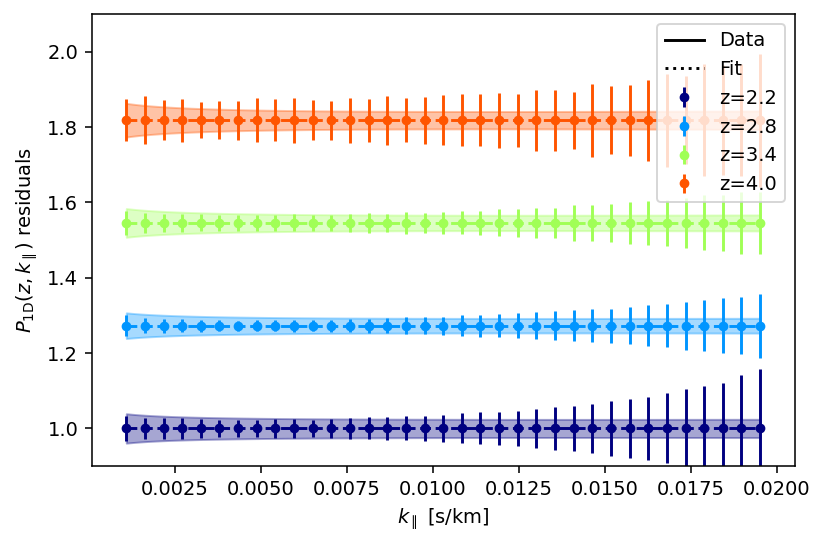

In [10]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

In [11]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [24]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.02
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.49080548 0.48612334 0.51187458 0.50023369 0.49593229 0.50133376
 0.50868255 0.48173083 0.49775104 0.48330878]
As = 2.079772057647453e-09 , 1e-09 , 3.2e-09
ns = 0.9626409683018506 , 0.88 , 1.05
ln_tau_0 = 0.002374916763687507 , -0.1 , 0.1
ln_sigT_kms_0 = 0.00018695067208385208 , -0.4 , 0.4
ln_gamma_0 = -0.0016270852257781743 , -0.2 , 0.2
ln_kF_0 = 0.0005335027471326248 , -0.2 , 0.2
ln_tau_1 = 0.0034730194386792257 , -0.2 , 0.2
ln_sigT_kms_1 = -0.014615332947631898 , -0.4 , 0.4
ln_gamma_1 = -0.0017991664299424892 , -0.4 , 0.4
ln_kF_1 = -0.01335297861040352 , -0.4 , 0.4


In [25]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [26]:
minimizer.minimize(compute_hesse=True)

In [27]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

3.9920245450921616e-05

In [28]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

2.309230808943042

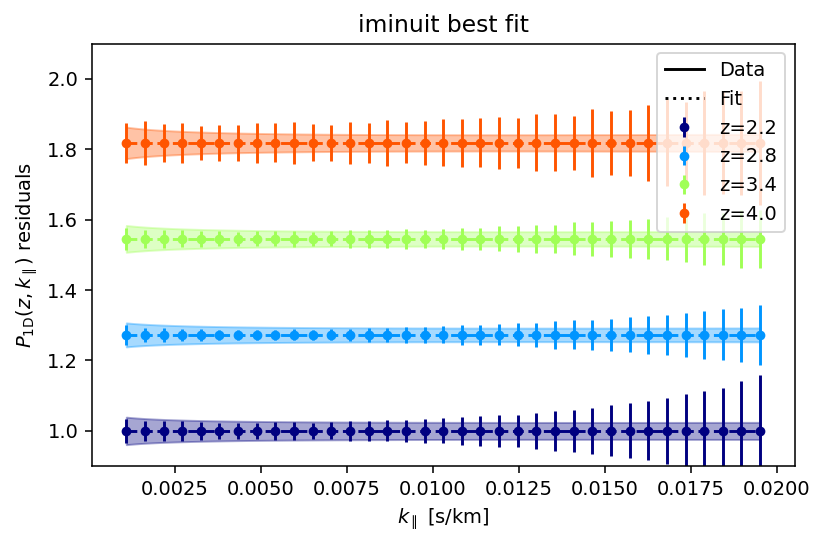

In [29]:
minimizer.plot_best_fit(plot_every_iz=3)

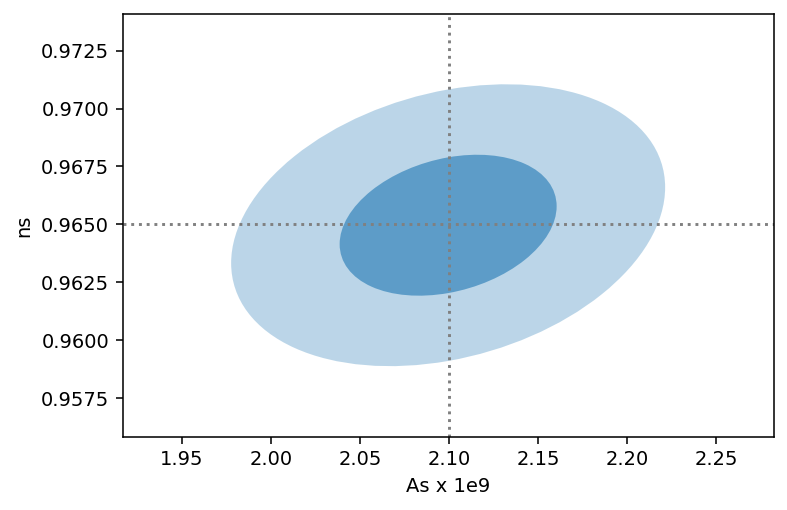

In [30]:
minimizer.plot_ellipses('As','ns')

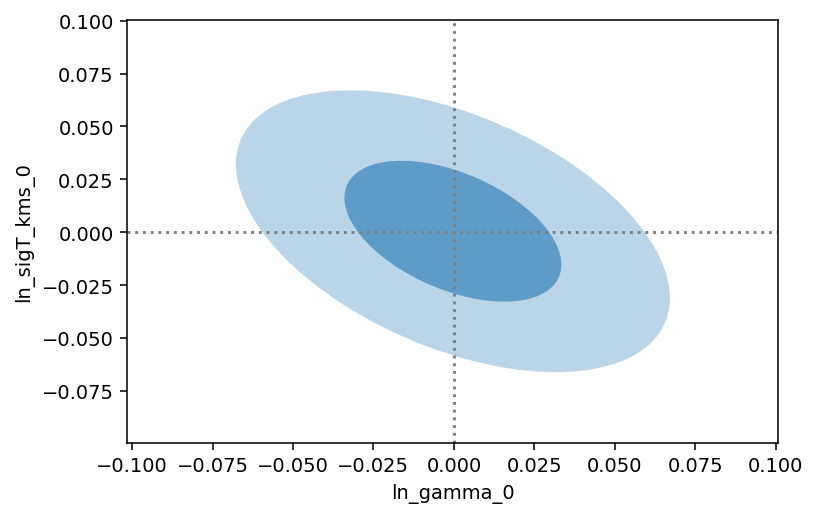

In [31]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

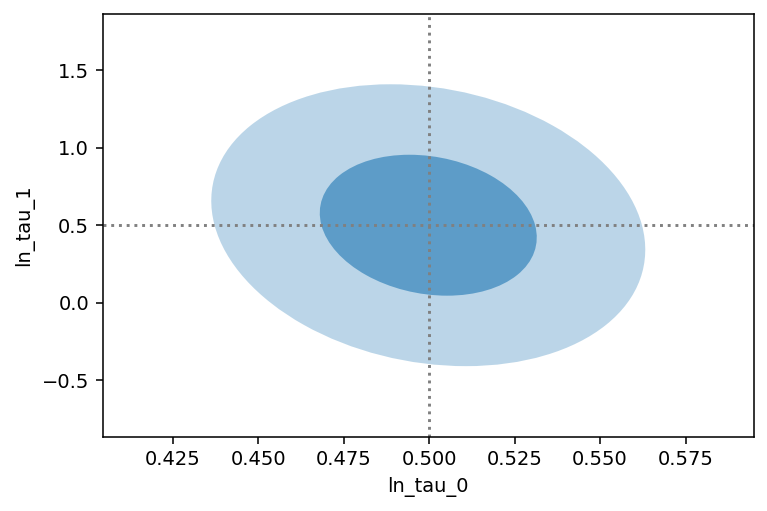

In [32]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [33]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 153.5                      │              Nfcn = 707              │
│ EDM = 1.1e-06 (Goal: 0.0001)     │           time = 18.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.500   │   0.029   │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.02    │            │            │         │         │       │
│ 2 │ x2   │   0.500   │   0.033   │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.04    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.09    │            │            │         │         │       │
│ 5 │ x5   │   0.500   │   0.032   │            │            │         │         │       │
│ 6 │ x6   │    0.5    │    0.5    │            │            │         │         │       │
│ 7 │ x7   │    0.5    │    0.8    │            │            │         │         │       │
│ 8 │ x8   │    0.5    │    0.4    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │  0.000824  0.000195  0.000178 -0.000842   0.00123  8.59e-05  -0.00631   0.00987  -0.00461  -0.00134 │
│ x1 │  0.000195  0.000386  6.01e-05 -0.000585  0.000743 -0.000114  -0.00341   0.00594  -0.00252 -0.000856 │
│ x2 │  0.000178  6.01e-05   0.00112 -0.000541   0.00162  0.000308  -0.00313   0.00417  -0.00129 -0.000618 │
│ x3 │ -0.000842 -0.000585 -0.000541   0.00199  -0.00212  0.000439    0.0104   -0.0172   0.00892   0.00267 │
│ x4 │   0.00123  0.000743   0.00162  -0.00212    0.0079 -0.000727   -0.0281    0.0541   -0.0195  -0.00412 │
│ x5 │  8.59e-05 -0.000114  0.000308  0.000439 -0.000727   0.00105   0.00722   -0.0143   0.00726   0.00212 │
│ x6 │  -0.00631  -0.00341  -0.00313    0.0104   -0.0281   0.00722     0.209    -0.359     0.178    0.0453 │
│ x7 │   0.00987   0.00594   0.00417   -0.0172    0.0541   -0.0143    -0.359     0.664    -0.307   -0.0626 │
│ x8 │  -0.00461  -0.00252  -0.00129   0.00892   -0.0195   0.00726     0.178    -0.307      0.17    0.0332 │
│ x9 │  -0.00134 -0.000856 -0.000618   0.00267  -0.00412   0.00212    0.0453   -0.0626    0.0332    0.0239 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [34]:
minimizer.minimizer.errors

<ErrorView x0=0.028699078593157314 x1=0.019639609025390248 x2=0.0334145415877491 x3=0.04455661273669534 x4=0.08890567066981267 x5=0.032334881589007804 x6=0.4567436448180748 x7=0.8148975983631097 x8=0.4120595455602817 x9=0.1545954931735741>

In [35]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(-3.9330629808126405e-05, 0.00668290831754982)